In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import numpy as np
from glob import glob
import tqdm

%matplotlib inline

In [2]:
import matplotlib as mpl

# Load the data.

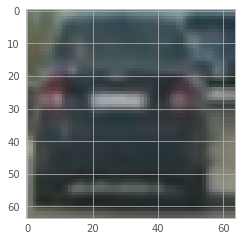

In [3]:
img = mpimage.imread('data/vehicles/vehicles/GTI_MiddleClose/image0000.png')
plt.imshow(img)

In [4]:
subKeys = {
    'vehicles': ['GTI_Far', 'GTI_Left', 'GTI_Right', 'GTI_MiddleClose'],
    'non-vehicles': ['GTI'],
}

In [5]:
paths = []
for mainKey in subKeys.keys():
    for subKey in subKeys[mainKey]:
        basePath = './data/%s/%s/%s/*.png' % (mainKey, mainKey, subKey)
        paths.extend([
            (
                int(path.split('/')[-1].replace('.png', '').replace('image', '')),
                mainKey,
                subKey,
                path,
            )
            for path in glob(basePath)
        ])

In [6]:
paths[0]

(178,
 'non-vehicles',
 'GTI',
 './data/non-vehicles/non-vehicles/GTI/image178.png')

In [7]:
ids = [x[0] for x in paths]
Y = [
    0 if veh == 'non-vehicles' else (subKeys['vehicles'].index(gti)+1)
    for (i, veh, gti, path)
    in paths
]
images = [
    mpimage.imread(path)
    for (i, veh, gti, path) in tqdm.tqdm_notebook(paths, unit='path')
]

HBox(children=(IntProgress(value=0, max=6726), HTML(value='')))

IDs are non-unique, so useless.

In [8]:
len(ids), len(set(ids))

(6726, 3901)

Images fit comfortably in memory, however.

In [9]:
d = images[0].dtype
print('%.3g MB' % (sum([x.size for x in images]) * d.alignment / 1024. / 1024.,))

315 MB


# Visualize a colorspace.

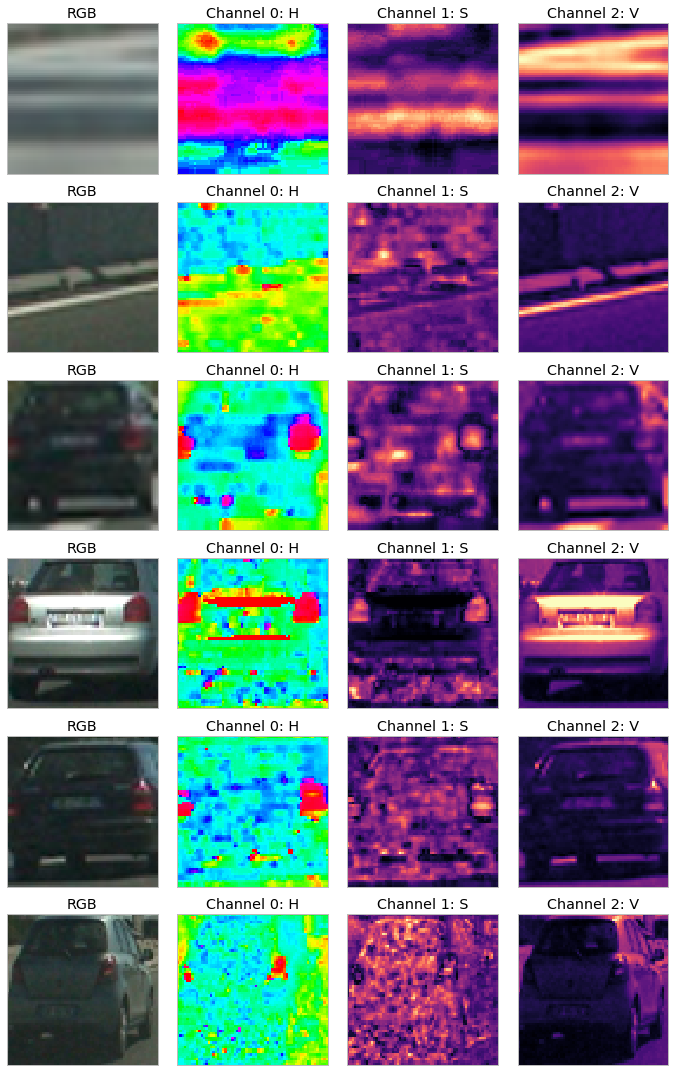

In [10]:
import cv2
def showCspace(img, cspace, axes=None):
    if axes is None:
        fig, axes = plt.subplots(ncols=4, figsize=(20, 6))
    if cspace != 'RGB':
        cvt = cv2.cvtColor(img, getattr(cv2, 'COLOR_RGB2%s' % cspace))
    else:
        cvt = img
    for i, ax in enumerate(axes):
        if i == 0:
            ax.imshow(img)
            ax.set_title('RGB')
        else:
            if len(cspace) == 3:
                c = cspace[i-1]
            else:
                assert cspace == 'YCrCb'
                c = ['Y', 'Cr', 'Cb'][i-1]
                
            if c == 'H':
                cmap = 'hsv'
            else:
                cmap = 'magma'
            ax.imshow(cvt[:, :, i-1], cmap=cmap)
            
            ax.set_title('Channel %d: %s' % (i-1, c))
        ax.set_xticks([])
        ax.set_yticks([])
    return axes

npix = 6
fig, axes = plt.subplots(ncols=4, nrows=npix, figsize=(10, 10. / 4 * npix))
for i in range(npix):
    iimg = [0, 1000, 4000, 5000, 5500, 5600][i]
    showCspace(images[iimg], 'HSV', axes=axes[i]);
fig.tight_layout()

# Fit a detector.

In [11]:
# from importlib import reload

In [12]:
# import tqdm
# from collections import defaultdict
# from sklearn.externals.joblib import Parallel, delayed
# class Callback(object):
#     completed = defaultdict(int)
#     def __init__(self, index, parallel):
#         from IPython.core.debugger import set_trace; set_trace()
#         self.index = index
#         self.parallel = parallel
#         self.pbar = tqdm.tqdm_notebook()
        
#     def __call__(self, index):
#         CallBack.completed[self.parallel] += 1
#         print("done with {}".format(CallBack.completed[self.parallel]))
#         self.pbar.update()
#         if self.parallel._original_iterable:
#             self.parallel.dispatch_next()
            
# import  sklearn.externals.joblib.parallel
# sklearn.externals.joblib.parallel.CallBack = CallBack

In [13]:
# import sklearn.model_selection._search
# reload(sklearn.model_selection._search)

In [14]:
import vehicleDetection
import vehicleDetection.search_classify
import vehicleDetection.detector
import vehicleDetection.lesson_functions
# reload(vehicleDetection)
# reload(vehicleDetection.search_classify)
# reload(vehicleDetection.detector)
# reload(vehicleDetection.lesson_functions)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
detector = vehicleDetection.detector.Detector()

Using RandomizedSearchCV.


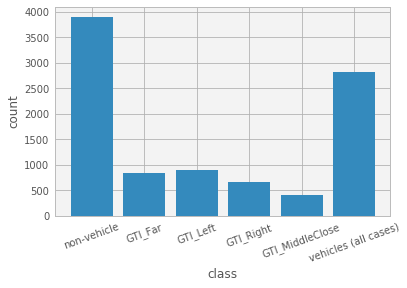

In [16]:
fig, ax = plt.subplots()
#classLabels = list(sorted(set(Y)))
classLabels = [0, 1, 2, 3, 4]
x = []
y = []
x.extend(classLabels)
y.extend([Y.count(label) for label in classLabels])
x.append(5)
y.append(np.array(Y).astype(bool).sum())
ax.bar(x, y)
ax.set_xticks(range(6))
classLabelNames = ['non-vehicle']
classLabelNames.extend(subKeys['vehicles'])
classLabelNames.append('vehicles (all cases)')
ax.set_xticklabels(classLabelNames, rotation=20);
ax.set_ylabel('count')
ax.set_xlabel('class');

In [ ]:
%%time
indices = np.arange(len(images))
np.random.shuffle(indices)
n = 1000
imageWindows = [images[i] for i in indices[:n]]
classes = [int(bool(Y[i])) for i in indices[:n]]
detector.fit(
    imageWindows, 
    classes,
)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


HBox(children=(IntProgress(value=0, max=384), HTML(value='')))

In [18]:
scores = [sc.mean_validation_score for sc in detector.clf.grid_scores_]
Cs = [sc.parameters['C'] for sc in detector.clf.grid_scores_]
gammas = [sc.parameters['gamma'] for sc in detector.clf.grid_scores_]
Cflat = list(sorted(set(Cs)))
gammaflat = list(sorted(set(gammas)))
grid = np.zeros((len(Cflat), len(gammaflat)))

for score, C, gamma in zip(scores, Cs, gammas):
    iC = Cflat.index(C)
    ig = gammaflat.index(gamma)
    grid[iC, ig] = score
        
fig, ax = plt.subplots(figsize=(16,9))
im = ax.imshow(grid, origin='lower', interpolation='none', cmap='hot')
fig.colorbar(im, label='score')

# sc = ax.scatter(np.log10(gammas), np.log10(Cs), c=scores)
# fig.colorbar(sc, label='score')

C = detector.clf.best_params_['C']
gamma = detector.clf.best_params_['gamma']
ax.scatter(gammaflat.index(gamma), Cflat.index(C), label='best', color='grey', s=256)

ax.set_xticks(range(len(gammaflat)))
ax.set_yticks(range(len(Cflat)))
logformat = lambda n: '$10^{%.2g}$' % np.log10(n)
lfm = lambda l: [logformat(n) for n in l]
ax.set_xticklabels(lfm(gammaflat))
ax.set_yticklabels(lfm(Cflat))

ax.set_title('hyperparameter search')
ax.set_xlabel('$\log_{10}(\gamma)$')
ax.set_ylabel('$\log_{10}(C)$');
ax.legend()

NotFittedError: This RandomizedSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
def predict(image):
    feat = detector.featurize(image)
    return detector.clf.predict(feat.reshape((1, -1)))

In [ ]:
iimg = 0
predict(images[iimg]), paths[iimg]

In [ ]:
fig, ax = plt.subplots()
ax.hist(classes, color='black', label='data', alpha=.5);
ax.hist(np.stack([predict(image) for image in imageWindows]), color='red', label='predictions', alpha=.5)
ax.legend()
ax.set_xticks([0, 1])
ax.set_xticklabels(['non-vehicle', 'vehicle'])

In [ ]:
fig, ax = plt.subplots()
ax.hist(scores)
ax.set_title('hyperparameter search')
ax.set_xlabel('score')
ax.set_ylabel('bin counts')

In [ ]:
img = mpimage.imread('test_images/test1.jpg')
windows = vehicleDetection.lesson_functions.slide_window(img)

In [ ]:
%%time
bboxes = detector.detect(img)

In [ ]:
windows = [w for w in detector.generateWindows(img)]
np.random.shuffle(windows)

In [ ]:
nwin = 32
windows[:nwin]

fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(
    vehicleDetection.lesson_functions.draw_boxes(
        img, windows[:nwin], thick=2,
    )
)
ax.set_xticks([])
ax.set_yticks([]);
ax.set_title('Some candidate bounding boxes')

In [ ]:
ax = detector.drawDetect(img)
ax.set_title('Raw detected bounding boxes')

In [ ]:
heatmap = detector.heat(img.shape, detector.rawDetect(img))
thr = 1
heatmap[heatmap <= thr] = 0
fig, ax = plt.subplots()
im = ax.imshow(heatmap[:, :, 0], cmap=mpl.cm.hot)
fig.colorbar(im)
ax.set_xticks([])
ax.set_yticks([]);
ax.set_title('heatmap thresholded at %d' % thr)

In [ ]:
heatmap.min(), heatmap.max()

In [ ]:
fig, ax = plt.subplots()
nz = heatmap[heatmap>0]
ax.hist(nz.ravel());
ax.set_title('histogram of nonzero parts of heatmap thresholded at %d' % thr);

In [ ]:
labels = detector.detect(img, threshold=thr)[0][:, :, 0]
fig, ax = plt.subplots()
ax.imshow(labels, cmap=mpl.cm.rainbow)
ax.set_xticks([])
ax.set_yticks([]);
ax.set_title('Unique components of heatmap thresholded at %d' % thr)

In [ ]:
# from IPython.c~ore.debugger import set_trace; set_trace()
ax = detector.drawHeat(img, threshold=thr)
ax.set_title('Outer bounding box for threshold=%d components' % thr)